<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Collect-list-of-files-and-split-into-train-and-test-sets" data-toc-modified-id="Collect-list-of-files-and-split-into-train-and-test-sets-2">Collect list of files and split into train and test sets</a></span></li><li><span><a href="#Gather-data-about-the-training-set" data-toc-modified-id="Gather-data-about-the-training-set-3">Gather data about the training set</a></span></li><li><span><a href="#Plot-intervals-between-price-changes" data-toc-modified-id="Plot-intervals-between-price-changes-4">Plot intervals between price changes</a></span></li><li><span><a href="#Plot-price-history-preceding-price-drops" data-toc-modified-id="Plot-price-history-preceding-price-drops-5">Plot price history preceding price drops</a></span></li><li><span><a href="#Plot-volatility-preceding-price-drops" data-toc-modified-id="Plot-volatility-preceding-price-drops-6">Plot volatility preceding price drops</a></span></li><li><span><a href="#Plot-feature-correlations" data-toc-modified-id="Plot-feature-correlations-7">Plot feature correlations</a></span></li><li><span><a href="#Plot-feature-distributions" data-toc-modified-id="Plot-feature-distributions-8">Plot feature distributions</a></span></li></ul></div>

# Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import os.path
import random
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import re
import scipy
import plotly.express as px
import utils.bookdroputils as bd
%matplotlib inline

# Collect list of files and split into train and test sets

Each file is the complete price history for one product in the dataset.

In [8]:
# Specify path to the data files
data_folder = os.path.join('data','paperbacks')
# Collect list of all files
file_list = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]
# Split list into train and test sets
train, test = train_test_split(file_list, test_size=0.2, random_state=777)

# Gather data about the training set

In [10]:
# Any time the price changes, store the time elapsed since the last change
intervals = list()

# Number of timepoints considered 'recent'
recent = 120
# Number of timepoints to search ahead for a price drop
future = 60
# Fraction of the price considered a 'drop'
# E.g., 0.1 for a 10% price drop
drop_frac = .1

# Keep the price history, volatility, and class label
# for each sample
history = []
volatility = []
label = []

# Engineered features of each sample
features = []

# Display messages when progress crosses this threshold
progress_threshold = .25
num_processed = 0
verbose = False

for file_name in train:
    # Read file
    df = pd.read_csv(os.path.join(data_folder, file_name))
    # Drop missing values
    df.dropna(inplace=True)
    # Convert to array
    prices = np.array(df['price'])
    
    # Sample data at 1-month intervals, starting at a random point in time
    for k in range(
            random.randint(0, 30) + recent + 5, df.shape[0] - future - 30, 60):
        
        # Compute the engineered features
        features.append(bd.compute_features(prices[:k + 1], drop_frac))
        
        # EDA
        # Normalize the prices
        prices_scaled = bd.scale_prices(prices[:k + 1])
        # Store the prices history
        history.append(prices_scaled[(k - recent + 1):(k + 1)])
        # Store the volatility
        volatility.append(np.std(prices_scaled[(k - recent + 1):(k + 1)]))

        # Store the class label
        if np.any(prices[(k + 1):(k + future + 1)] < (1 - drop_frac) *
                  prices[k]):
            label.append(1)
        else:
            label.append(0)
    
    # Gather data on intervals between price changes
    # Determine, at each index, if a change occurred
    diffs = np.abs(np.diff(prices)) > 0
    # Create a string where price changes are 1s and
    # timepoints with no change are 0s
    s = "".join(diffs.astype(int).astype(str))
    # Locate all sequences of identical prices
    identical = re.findall('0+', s)
    # Locate all sequences of consecutive changes
    consecutive = re.findall('1[^0]+', s)
    # Compute the interval length for each type of change
    # Note that the time resolution is 12h, and the
    # intervals are expressed in days
    intervals_i = [(len(i) + 1) / 2 for i in identical]
    intervals_c = list()
    for i in consecutive:
        for j in range(len(i) - 1):
            intervals_c.append(.5)
    # Append to the list
    intervals = intervals + intervals_i + intervals_c
    
    # Show progress
    num_processed += 1
    if num_processed / len(train) > progress_threshold:
        if verbose:
            print(str(round(progress_threshold*100))+'% done')
        progress_threshold += .25
        
    
# Convert observations to arrays
intervals_cleaned = np.array(intervals)
history_array = np.array(history)
label_array = np.array(label)
volatility_array = np.array(volatility)
feature_array = np.array(features)

25.0% done
50.0% done
75.0% done


# Plot intervals between price changes

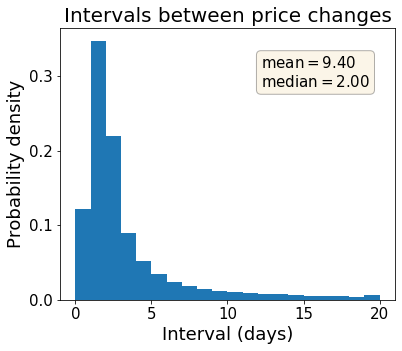

In [11]:
# Set the maximum value of the histogram
max_x = 20
# Apply this as an upper bound
intervals_cleaned[intervals_cleaned > max_x] = max_x

# Plot the histogram
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)
ax1.hist(intervals, np.arange(0, max_x + 1, 1), density=True)
ax1.set_title("Intervals between price changes", fontsize=20)
ax1.set_xlabel("Interval (days)", fontsize=18)
ax1.set_ylabel("Probability density", fontsize=18)
plt.xticks([0, 5, 10, 15, 20], fontsize=15)
plt.yticks([0, .1, .2, .3], fontsize=15)

# Show descriptive statistics
mu = np.mean(intervals)
med = np.median(intervals)
textstr = '\n'.join(
    (r'$\mathrm{mean}=%.2f$' % (mu, ), r'$\mathrm{median}=%.2f$' % (med, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

ax1.text(0.6,
         0.9,
         textstr,
         transform=ax1.transAxes,
         fontsize=15,
         verticalalignment='top',
         bbox=props)
plt.show()

# Plot price history preceding price drops

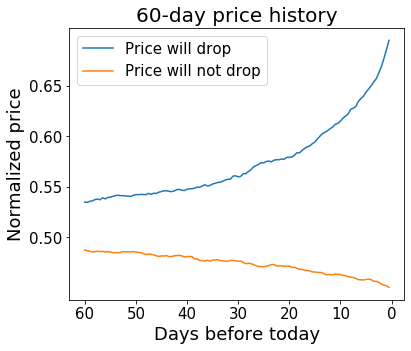

In [12]:
# Balance the classes
undersample = RandomUnderSampler(sampling_strategy='majority')
history_balanced, label_balanced = undersample.fit_resample(
    history_array, label_array)

# Split data by class
prices_drop = history_balanced[label_balanced == 1]
prices_no_drop = history_balanced[label_balanced == 0]

# Generate the plot
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)
plt.xticks(ticks=np.arange(-60, 10, 10),
           labels=np.arange(60, -10, -10),
           fontsize=15)
plt.yticks(np.arange(.5, .7, .05), fontsize=15)
a, = ax1.plot(np.arange(0, 60, .5) - 60, np.nanmean(prices_drop, axis=0))
b, = ax1.plot(np.arange(0, 60, .5) - 60, np.nanmean(prices_no_drop, axis=0))
plt.legend([a, b], ['Price will drop', 'Price will not drop'], fontsize=15)
ax1.set_title("60-day price history", fontsize=20)
ax1.set_xlabel("Days before today", fontsize=18)
ax1.set_ylabel("Normalized price", fontsize=18)
plt.show()

# Plot volatility preceding price drops

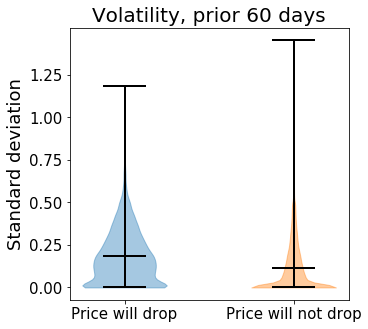

In [13]:
# Split data by class
std_drop = volatility_array[label_array==1]
std_no_drop = volatility_array[label_array==0]

# Generate the plot
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

plt.xticks(ticks=[1,2],labels=['Price will drop','Price will not drop'],fontsize=15)
plt.yticks(np.arange(0,1.5,.25),fontsize=15)
violins = ax1.violinplot([np.squeeze(std_drop),np.squeeze(std_no_drop)],showmeans = True)
colors = ['#1f77b4','#ff7f0e']
for i in [0,1]:
    violins['bodies'][i].set_facecolor(colors[i])
    violins['bodies'][i].set_edgecolor(colors[i])
    violins['bodies'][i].set_alpha(.4)

ax1.set_title("Volatility, prior 60 days",fontsize=20)
ax1.set_ylabel("Standard deviation",fontsize=18)

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violins[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(2)
plt.show()

# Plot feature correlations

See the [slides](http://slides.book-drop.site/) (specifically slide 11) for an explanation of the features.

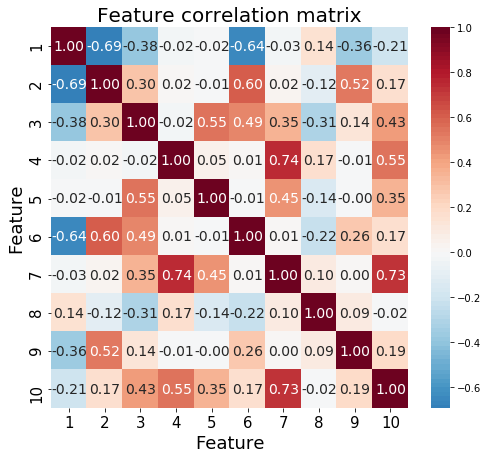

In [16]:
# Make a dataframe of features
df = pd.DataFrame(feature_array)

# Generate the plot
plt.figure(figsize=(8,7))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=sns.color_palette("RdBu_r", 100),annot_kws={"size": 14},fmt='.2f',center=0)

plt.title("Feature correlation matrix",fontsize=20)
plt.ylabel("Feature",fontsize=18)
plt.yticks(np.arange(.5,10.5,1), labels=[1,2,3,4,5,6,7,8,9,10],fontsize=15)
plt.xlabel("Feature",fontsize=18)
plt.xticks(np.arange(.5,10.5,1), labels=[1,2,3,4,5,6,7,8,9,10],fontsize=15)

plt.show()

# Plot feature distributions

(-50.940704541662825, 0.0)
(46.647265357335186, 0.0)
(85.91713011597344, 0.0)
(24.36640839513327, 1.4600205446825583e-130)
(45.30997021467318, 0.0)
(47.492465003930704, 0.0)
(53.679554227816666, 0.0)
(-27.963286852650224, 4.489613750849166e-171)
(27.59879511644306, 1.0114349270827294e-166)
(69.05333220032723, 0.0)


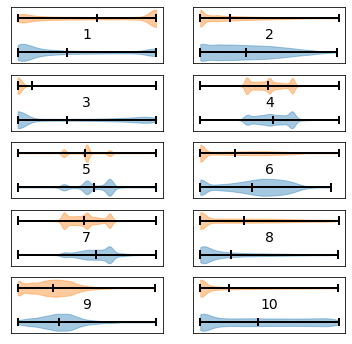

In [19]:
fig = plt.figure(figsize=(6,6))
for i  in range(10):
    drop = np.squeeze(feature_array[label_array==1,i])
    no_drop = np.squeeze(feature_array[label_array==0,i])
    
    s,p = scipy.stats.ttest_ind(drop,no_drop)
    print((s,p))
    ax=fig.add_subplot(5,2,i+1)
    violins = ax.violinplot([drop,no_drop],showmeans = True,vert=False)
    colors = ['#1f77b4','#ff7f0e']
    for k in [0,1]:
        violins['bodies'][k].set_facecolor(colors[k])
        violins['bodies'][k].set_edgecolor(colors[k])
        violins['bodies'][k].set_alpha(.4)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = violins[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(2)
    plt.yticks([])
    plt.xticks([])
    plt.text(0.5, 0.5, str(i+1), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=14)
plt.show()